In [13]:
import cv2 
import pickle
import matplotlib.pyplot as plt

cv2.imread("../../../data/sift_matching/images/taj1.jpg",0)

In [14]:
import glob

# imageList = ["taj1.jpg","taj2.jpg","eiffel1.jpg","eiffel2.jpg","liberty1.jpg","liberty2.jpg","robert1.jpg","tom1.jpg","ironman1.jpg","ironman2.jpg","ironman3.jpg","darkknight1.jpg","darkknight2.jpg","book1.jpg","book2.jpg"]
image_list = glob.glob("../../../data/matching/sonar_samples/*.png")

# Using opencv's sift implementation here

sift = cv2.SIFT_create()

def imageResizeTrain(image):
    maxD = 1024
    height,width = image.shape
    aspectRatio = width/height
    if aspectRatio < 1:
        newSize = (int(maxD*aspectRatio),maxD)
    else:
        newSize = (maxD,int(maxD/aspectRatio))
    image = cv2.resize(image,newSize)
    return image

def imageResizeTest(image):
    maxD = 1024
    height,width,channel = image.shape
    aspectRatio = width/height
    if aspectRatio < 1:
        newSize = (int(maxD*aspectRatio),maxD)
    else:
        newSize = (maxD,int(maxD/aspectRatio))
    image = cv2.resize(image,newSize)
    return image

def computeSIFT(image):
    return sift.detectAndCompute(image, None)

bf = cv2.BFMatcher()
def calculateMatches(des1,des2):
    matches = bf.knnMatch(des1,des2,k=2)
    topResults1 = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            topResults1.append([m])
            
    matches = bf.knnMatch(des2,des1,k=2)
    topResults2 = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            topResults2.append([m])
    
    topResults = []
    for match1 in topResults1:
        match1QueryIndex = match1[0].queryIdx
        match1TrainIndex = match1[0].trainIdx

        for match2 in topResults2:
            match2QueryIndex = match2[0].queryIdx
            match2TrainIndex = match2[0].trainIdx

            if (match1QueryIndex == match2TrainIndex) and (match1TrainIndex == match2QueryIndex):
                topResults.append(match1)
    return topResults

def fetchKeypointFromFile(i):
    filepath = "data/matching/keypoints/" + str(image_list[i].split('.')[0]) + ".txt"
    keypoint = []
    file = open(filepath,'rb')
    deserializedKeypoints = pickle.load(file)
    file.close()
    for point in deserializedKeypoints:
        temp = cv2.KeyPoint(
            x=point[0][0],
            y=point[0][1],
            size=point[1],
            angle=point[2],
            response=point[3],
            octave=point[4],
            class_id=point[5]
        )
        keypoint.append(temp)
    return keypoint

def fetchDescriptorFromFile(i):
    filepath = "data/matching/descriptors/" + str(image_list[i].split('.')[0]) + ".txt"
    file = open(filepath,'rb')
    descriptor = pickle.load(file)
    file.close()
    return descriptor

def calculateResultsFor(i,j):
    keypoint1 = fetchKeypointFromFile(i)
    descriptor1 = fetchDescriptorFromFile(i)
    keypoint2 = fetchKeypointFromFile(j)
    descriptor2 = fetchDescriptorFromFile(j)
    matches = calculateMatches(descriptor1, descriptor2)
    score = calculateScore(len(matches),len(keypoint1),len(keypoint2))
    plot = getPlotFor(i,j,keypoint1,keypoint2,matches)
    print(len(matches),len(keypoint1),len(keypoint2),len(descriptor1),len(descriptor2))
    print(score)
    plt.imshow(plot),plt.show()

def getPlotFor(i,j,keypoint1,keypoint2,matches):
    image1 = imageResizeTest(cv2.imread("data/matching/images/" + image_list[i]))
    image2 = imageResizeTest(cv2.imread("data/matching/images/" + image_list[j]))
    return getPlot(image1,image2,keypoint1,keypoint2,matches)

def calculateScore(matches,keypoint1,keypoint2):
    return 100 * (matches/min(keypoint1,keypoint2))

def getPlot(image1,image2,keypoint1,keypoint2,matches):
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    matchPlot = cv2.drawMatchesKnn(
        image1,
        keypoint1,
        image2,
        keypoint2,
        matches,
        None,
        [255,255,255],
        flags=2
    )
    return matchPlot


imagesBW = []
for imageName in image_list:
    imagePath = "data/sift_matching/images/" + str(imageName)
    imagesBW.append(imageResizeTrain(cv2.imread(imagePath,0))) # flag 0 means grayscale
    
keypoints = []
descriptors = []
for i,image in enumerate(imagesBW):
    print("Starting for image: " + image_list[i])
    keypointTemp, descriptorTemp = computeSIFT(image)
    keypoints.append(keypointTemp)
    descriptors.append(descriptorTemp)
    print("  Ending for image: " + image_list[i])
    
for i,keypoint in enumerate(keypoints):
    deserializedKeypoints = []
    filepath = "data/matching/keypoints/" + str(image_list[i].split('.')[0]) + ".txt"
    for point in keypoint:
        temp = (point.pt, point.size, point.angle, point.response, point.octave, point.class_id)
        deserializedKeypoints.append(temp)
    with open(filepath, 'wb') as fp:
        pickle.dump(deserializedKeypoints, fp)    
        
for i,descriptor in enumerate(descriptors):
    filepath = "data/matching/descriptors/" + str(image_list[i].split('.')[0]) + ".txt"
    with open(filepath, 'wb') as fp:
        pickle.dump(descriptor, fp)

AttributeError: 'NoneType' object has no attribute 'shape'

In [15]:
calculateResultsFor(8, 9)

FileNotFoundError: [Errno 2] No such file or directory: 'data/matching/keypoints/.txt'

# Matching based on SIFT Features

In [16]:
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

def match_images(image_path1: str, image_path2: str):
    # Load the images
    img1 = cv2.imread(image_path1, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image_path2, cv2.IMREAD_GRAYSCALE)

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect and compute SIFT descriptors for both images
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # Check if both images have features
    if des1 is None or des2 is None:
        print(f"No features detected in one or both images: {image_path1}, {image_path2}")
        return

    # Initialize BFMatcher
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

    # Match descriptors
    matches = bf.match(des1, des2)

    # Sort matches by distance (the lower the better)
    matches = sorted(matches, key=lambda x: x.distance)

    # Draw first 10 matches
    img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Display the image with matplotlib
    plt.imshow(img3)
    plt.show()

def calc_euclidian_distance(keypoint1, keypoint2, img1_shape, img2_shape):
    x1, y1 = keypoint1.pt
    x2, y2 = keypoint2.pt

    # Calculate the average size of the images
    avg_size = np.mean([img1_shape[0], img1_shape[1], img2_shape[0], img2_shape[1]])

    # Calculate and normalize the Euclidean distance
    distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    normalized_distance = distance / avg_size

    return normalized_distance

def match_with_others(image_list):
    # Separate the list into _1 and _2 images
    one_images = [img for img in image_list if '_1.' in img]
    two_images = [img for img in image_list if '_2.' in img]

    # Create a dictionary to map each _1 image to its corresponding _2 image
    one_two_map = {one_img: two_img for one_img, two_img in zip(one_images, two_images)}

    # Iterate over every _1 image
    for one_img in one_images:
        # Load the _1 image
        img1 = cv2.imread(one_img, cv2.IMREAD_GRAYSCALE)
        kp1, des1 = sift.detectAndCompute(img1, None)

        # Check if keypoints/descriptors are detected in the _1 image
        if des1 is None:
            print(f"Warning: No keypoints/descriptors detected in {one_img}. Skipping this image.")
            continue

        # Match with the corresponding _2 image
        if one_img in one_two_map:
            two_img_path = one_two_map[one_img]
            img2 = cv2.imread(two_img_path, cv2.IMREAD_GRAYSCALE)
            kp2, des2 = sift.detectAndCompute(img2, None)

            # Check if keypoints/descriptors are detected in the _2 image
            if des2 is None:
                print(f"Warning: No keypoints/descriptors detected in {two_img_path}. Skipping this image.")
                continue

            matches = bf.match(des1, des2)

            # Calculate the angles between corresponding keypoints
            angles = [calc_euclidian_distance(kp1[match.queryIdx], kp2[match.trainIdx], img1.shape, img2.shape) for match in matches]

            # Calculate the standard deviation of the angles
            score = np.std(angles)
            print(f"Matching score between {one_img} and {two_img_path}: {score}")
            img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
            plt.imshow(img3)
            plt.show()

        # Match with all the other _1 images
        for other_one_img in one_images:
            if other_one_img != one_img:
                img2 = cv2.imread(other_one_img, cv2.IMREAD_GRAYSCALE)
                kp2, des2 = sift.detectAndCompute(img2, None)

                # Check if keypoints/descriptors are detected in the other _1 image
                if des2 is None:
                    print(f"Warning: No keypoints/descriptors detected in {other_one_img}. Skipping this image.")
                    continue

                matches = bf.match(des1, des2)

                # Calculate the angles between corresponding keypoints
                angles = [calc_euclidian_distance(kp1[match.queryIdx], kp2[match.trainIdx], img1.shape, img2.shape) for match in matches]

                # Calculate the standard deviation of the angles
                score = np.std(angles)
                print(f"Matching score between {one_img} and {other_one_img}: {score}")
                img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
                plt.imshow(img3)
                plt.show()

In [17]:
image_list

['../../../data/matching/sonar_samples\\fish_a_1.png',
 '../../../data/matching/sonar_samples\\fish_a_2.png',
 '../../../data/matching/sonar_samples\\fish_b_1.png',
 '../../../data/matching/sonar_samples\\fish_b_2.png',
 '../../../data/matching/sonar_samples\\noise_a_1.png',
 '../../../data/matching/sonar_samples\\noise_a_2.png',
 '../../../data/matching/sonar_samples\\school_a_1.png',
 '../../../data/matching/sonar_samples\\school_a_2.png',
 '../../../data/matching/sonar_samples\\school_b_1.png',
 '../../../data/matching/sonar_samples\\school_b_2.png',
 '../../../data/matching/sonar_samples\\school_c_1.png',
 '../../../data/matching/sonar_samples\\school_c_2.png']

Matching score between ../../../data/matching/sonar_samples\fish_a_1.png and ../../../data/matching/sonar_samples\fish_a_2.png: 0.096987445316552


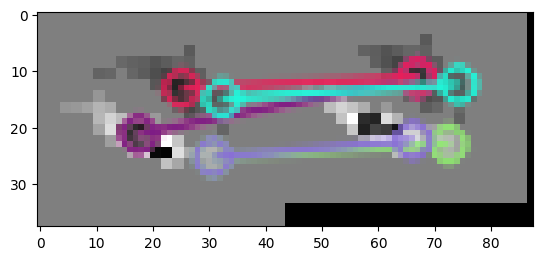

Matching score between ../../../data/matching/sonar_samples\fish_a_1.png and ../../../data/matching/sonar_samples\fish_b_1.png: 0.13062557921874304


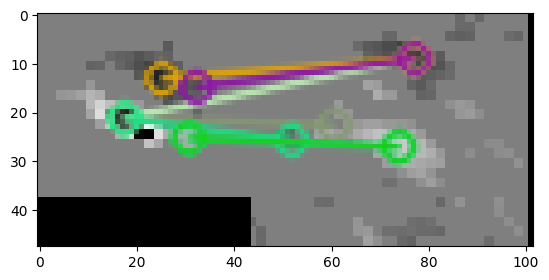

Matching score between ../../../data/matching/sonar_samples\fish_a_1.png and ../../../data/matching/sonar_samples\noise_a_1.png: 0.05741275392539223


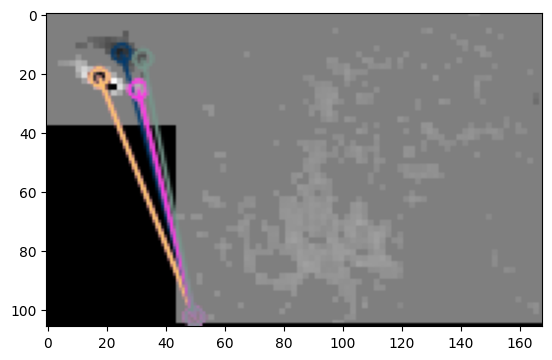

Matching score between ../../../data/matching/sonar_samples\fish_a_1.png and ../../../data/matching/sonar_samples\school_a_1.png: 0.1018236786245905


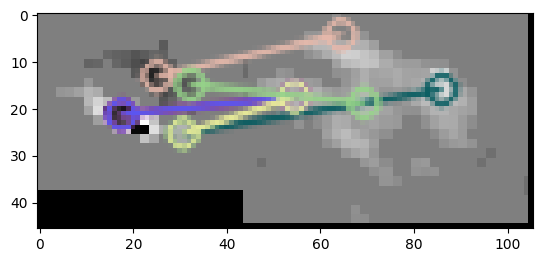

Matching score between ../../../data/matching/sonar_samples\fish_a_1.png and ../../../data/matching/sonar_samples\school_b_1.png: 0.19829829625580633


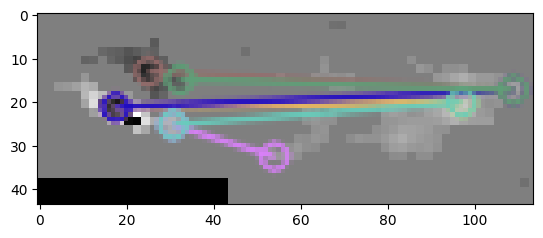

Matching score between ../../../data/matching/sonar_samples\fish_a_1.png and ../../../data/matching/sonar_samples\school_c_1.png: 0.10063400322369856


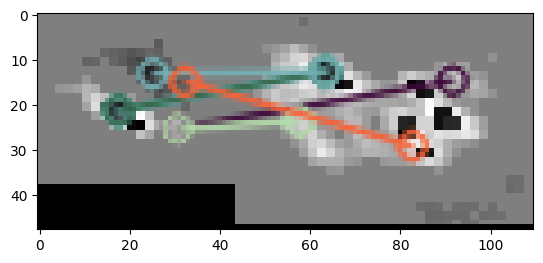

Matching score between ../../../data/matching/sonar_samples\fish_b_1.png and ../../../data/matching/sonar_samples\fish_b_2.png: 0.18301246594138315


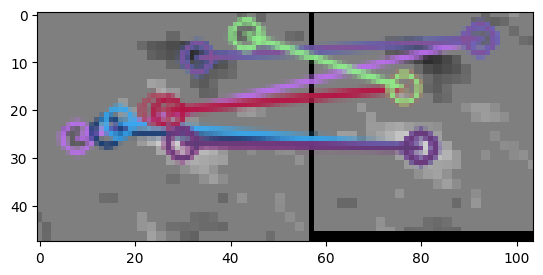

Matching score between ../../../data/matching/sonar_samples\fish_b_1.png and ../../../data/matching/sonar_samples\fish_a_1.png: 0.1362861122025002


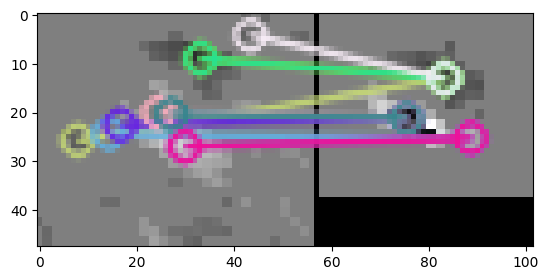

Matching score between ../../../data/matching/sonar_samples\fish_b_1.png and ../../../data/matching/sonar_samples\noise_a_1.png: 0.10171295770977135


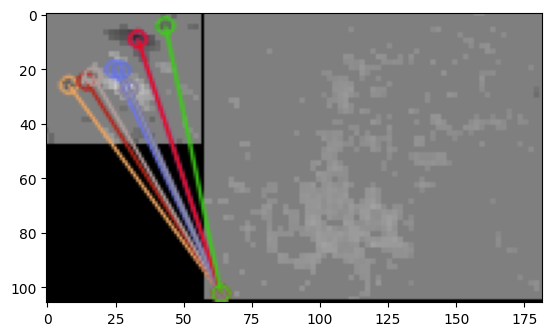

Matching score between ../../../data/matching/sonar_samples\fish_b_1.png and ../../../data/matching/sonar_samples\school_a_1.png: 0.15964697577003942


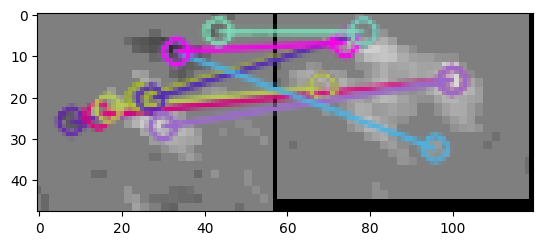

Matching score between ../../../data/matching/sonar_samples\fish_b_1.png and ../../../data/matching/sonar_samples\school_b_1.png: 0.24626782549630763


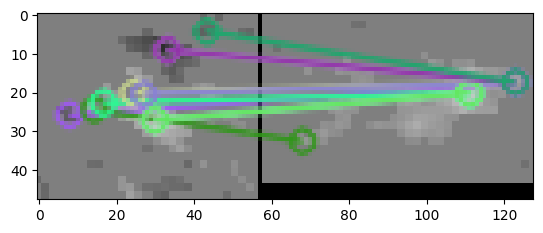

Matching score between ../../../data/matching/sonar_samples\fish_b_1.png and ../../../data/matching/sonar_samples\school_c_1.png: 0.14478749026802237


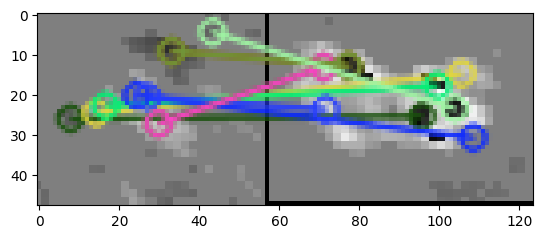

Matching score between ../../../data/matching/sonar_samples\school_a_1.png and ../../../data/matching/sonar_samples\school_a_2.png: 0.11891661924569726


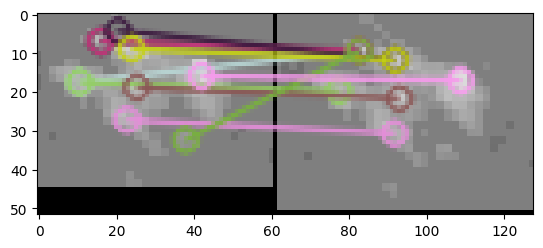

Matching score between ../../../data/matching/sonar_samples\school_a_1.png and ../../../data/matching/sonar_samples\fish_a_1.png: 0.12316433801039081


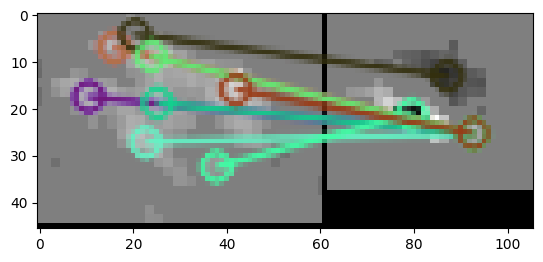

Matching score between ../../../data/matching/sonar_samples\school_a_1.png and ../../../data/matching/sonar_samples\fish_b_1.png: 0.12668978013512788


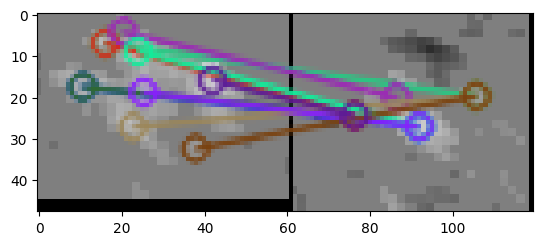

Matching score between ../../../data/matching/sonar_samples\school_a_1.png and ../../../data/matching/sonar_samples\noise_a_1.png: 0.08833580086919597


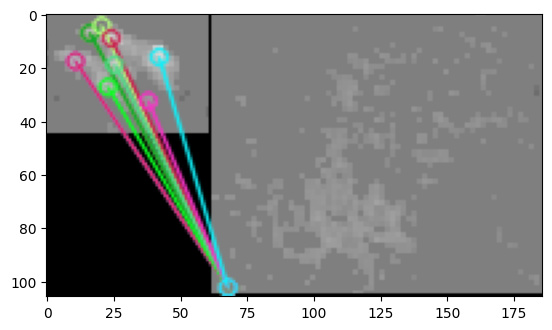

Matching score between ../../../data/matching/sonar_samples\school_a_1.png and ../../../data/matching/sonar_samples\school_b_1.png: 0.20523309516105046


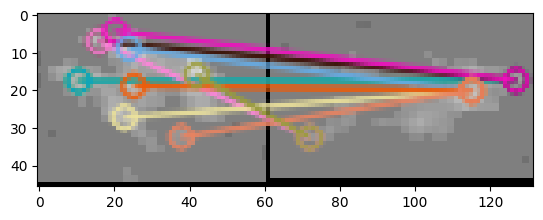

Matching score between ../../../data/matching/sonar_samples\school_a_1.png and ../../../data/matching/sonar_samples\school_c_1.png: 0.2326390764594217


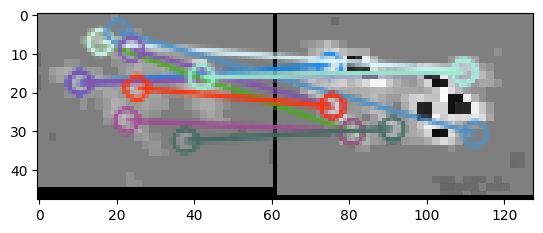

Matching score between ../../../data/matching/sonar_samples\school_b_1.png and ../../../data/matching/sonar_samples\school_b_2.png: 0.24729897013138621


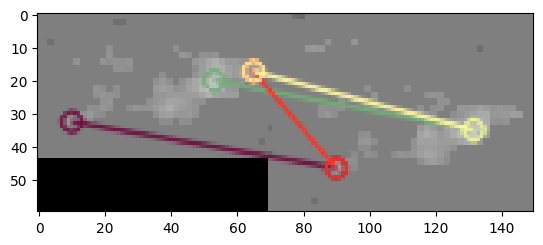

Matching score between ../../../data/matching/sonar_samples\school_b_1.png and ../../../data/matching/sonar_samples\fish_a_1.png: 0.12973630834538874


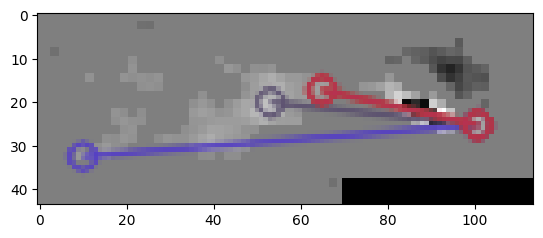

Matching score between ../../../data/matching/sonar_samples\school_b_1.png and ../../../data/matching/sonar_samples\fish_b_1.png: 0.2810449257488007


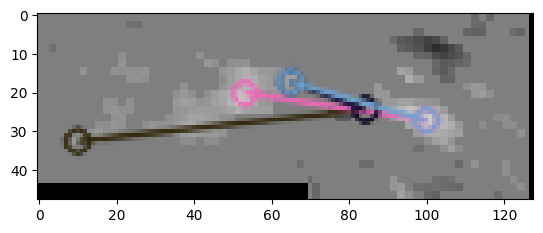

Matching score between ../../../data/matching/sonar_samples\school_b_1.png and ../../../data/matching/sonar_samples\noise_a_1.png: 0.16067004370128285


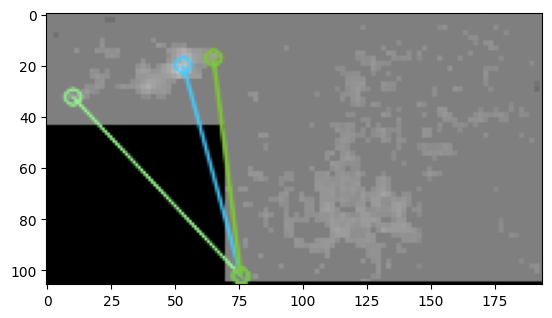

Matching score between ../../../data/matching/sonar_samples\school_b_1.png and ../../../data/matching/sonar_samples\school_a_1.png: 0.2985115693555643


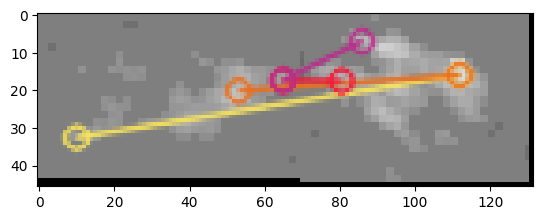

Matching score between ../../../data/matching/sonar_samples\school_b_1.png and ../../../data/matching/sonar_samples\school_c_1.png: 0.21982919286869876


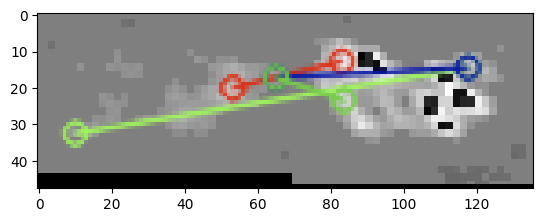

Matching score between ../../../data/matching/sonar_samples\school_c_1.png and ../../../data/matching/sonar_samples\school_c_2.png: 0.20128895459516857


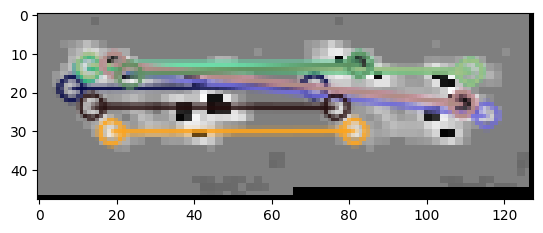

Matching score between ../../../data/matching/sonar_samples\school_c_1.png and ../../../data/matching/sonar_samples\fish_a_1.png: 0.135058798062524


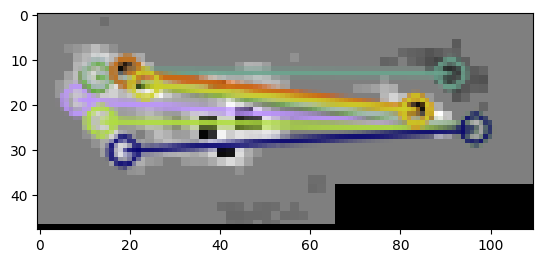

Matching score between ../../../data/matching/sonar_samples\school_c_1.png and ../../../data/matching/sonar_samples\fish_b_1.png: 0.14744137948029457


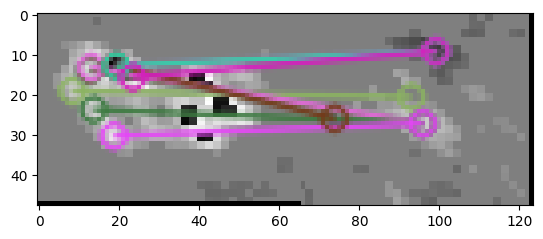

Matching score between ../../../data/matching/sonar_samples\school_c_1.png and ../../../data/matching/sonar_samples\noise_a_1.png: 0.06195303246449862


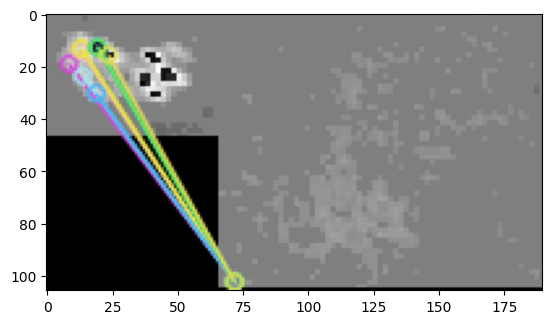

Matching score between ../../../data/matching/sonar_samples\school_c_1.png and ../../../data/matching/sonar_samples\school_a_1.png: 0.22956727659094578


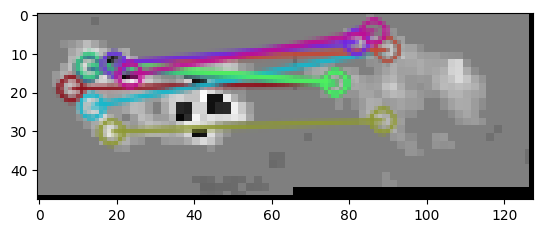

Matching score between ../../../data/matching/sonar_samples\school_c_1.png and ../../../data/matching/sonar_samples\school_b_1.png: 0.22273050855232335


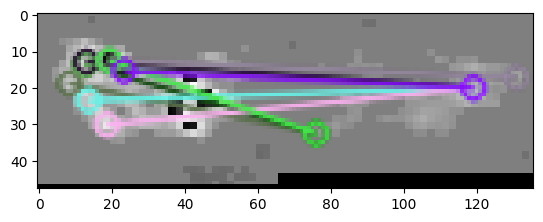

In [18]:
match_with_others(image_list)

# Mutual Information

In [19]:
from skimage.metrics import normalized_mutual_information
import matplotlib.pyplot as plt
from IPython.display import Markdown

def match_1_2_images(image_list, show_images=False):
    # Separate the list into _1 and _2 images
    one_images = [img for img in image_list if '_1.' in img]
    two_images = [img for img in image_list if '_2.' in img]

    # Create a dictionary to map each _1 image to its corresponding _2 image
    one_two_map = {one_img: two_img for one_img, two_img in zip(one_images, two_images)}

    # Iterate over every _1 image
    for one_img in one_images:
        # Load the _1 image
        img1 = cv2.imread(one_img, cv2.IMREAD_GRAYSCALE)

        # Match with the corresponding _2 image
        two_img = one_two_map[one_img]
        img2 = cv2.imread(two_img, cv2.IMREAD_GRAYSCALE)
        score = normalized_mutual_information(img1, img2)
        display(Markdown(f'Matching score between {one_img} and {two_img}: <span style="color: green">{score}</span>'))
        if show_images:
            display_images(one_img, img1, two_img, img2)

        # Match with all the other _1 images
        for other_one_img in one_images:
            if other_one_img != one_img:
                img2 = cv2.imread(other_one_img, cv2.IMREAD_GRAYSCALE)
                score = normalized_mutual_information(img1, img2)
                display(Markdown(f'Matching score between {one_img} and {other_one_img}: <span style="color: red">{score}</span>'))
                if show_images:
                    display_images(one_img, img1, other_one_img, img2)

def display_images(img1_name, img1, img2_name, img2):
    # Display the images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img1, cmap='gray')
    plt.title(f'Image: {img1_name}')
    plt.subplot(1, 2, 2)
    plt.imshow(img2, cmap='gray')
    plt.title(f'Image: {img2_name}')
    plt.show()

In [9]:
match_1_2_images(image_list)

# Matching based on normalized correlation

In [64]:
from scipy.signal import correlate2d

def match_1_2_images(image_list):
    # Separate the list into _1 and _2 images
    one_images = [img for img in image_list if '_1.' in img]
    two_images = [img for img in image_list if '_2.' in img]

    # Create a dictionary to map each _1 image to its corresponding _2 image
    one_two_map = {one_img: two_img for one_img, two_img in zip(one_images, two_images)}

    # Iterate over every _1 image
    for one_img in one_images:
        # Load the _1 image
        img1 = cv2.imread(one_img, cv2.IMREAD_GRAYSCALE)

        # Match with the corresponding _2 image
        two_img = one_two_map[one_img]
        img2 = cv2.imread(two_img, cv2.IMREAD_GRAYSCALE)
        score = correlate2d(img1, img2).mean()
        print(f"Matching score between {one_img} and {two_img}: {score}")
        display_images(one_img, img1, two_img, img2)

        # Match with all the other _1 images
        for other_one_img in one_images:
            if other_one_img != one_img:
                img2 = cv2.imread(other_one_img, cv2.IMREAD_GRAYSCALE)
                score = correlate2d(img1, img2).mean()
                print(f"Matching score between {one_img} and {other_one_img}: {score}")
                display_images(one_img, img1, other_one_img, img2)

Matching score between data/matching/sonar_samples\fish_a_1.png and data/matching/sonar_samples\fish_a_2.png: 109.55739031892504


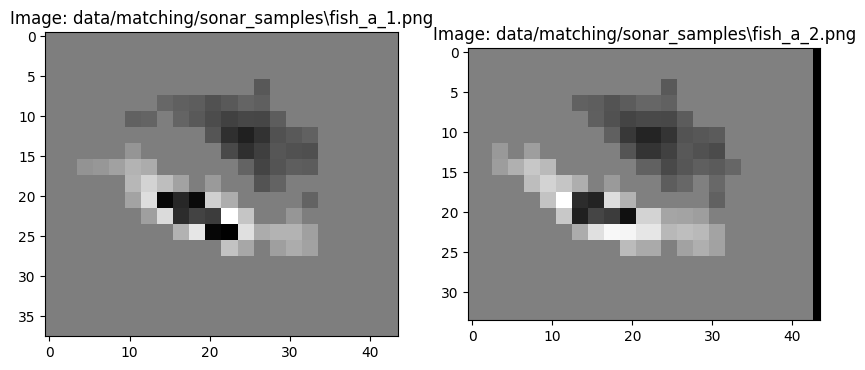

Matching score between data/matching/sonar_samples\fish_a_1.png and data/matching/sonar_samples\fish_b_1.png: 121.14152591729761


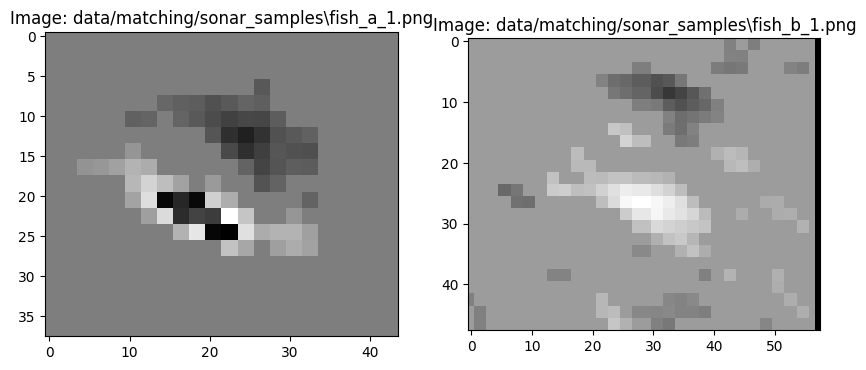

Matching score between data/matching/sonar_samples\fish_a_1.png and data/matching/sonar_samples\noise_a_1.png: 123.49231606716637


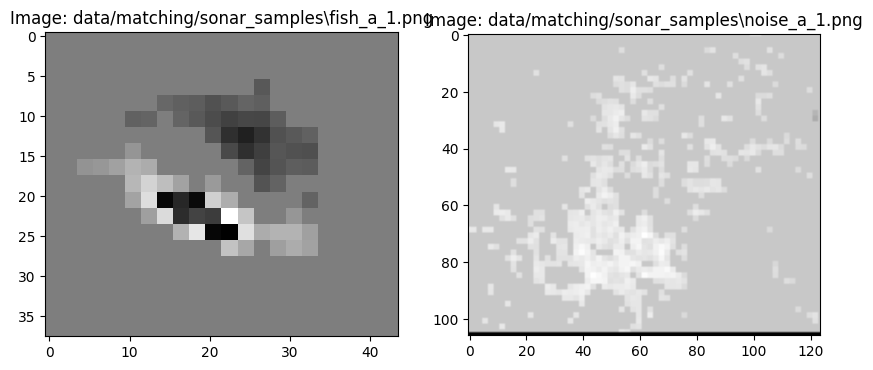

Matching score between data/matching/sonar_samples\fish_a_1.png and data/matching/sonar_samples\school_a_1.png: 118.74331612162938


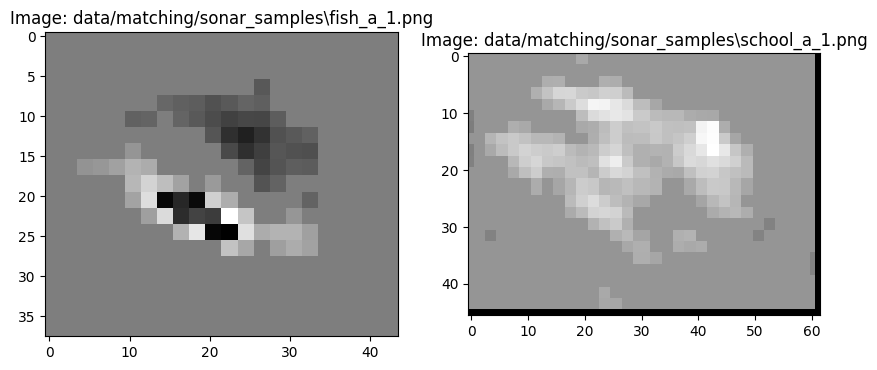

Matching score between data/matching/sonar_samples\fish_a_1.png and data/matching/sonar_samples\school_b_1.png: 119.10586692887578


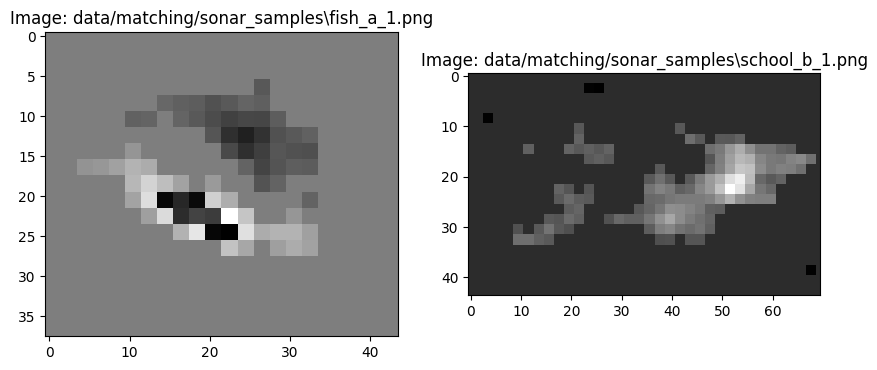

Matching score between data/matching/sonar_samples\fish_a_1.png and data/matching/sonar_samples\school_c_1.png: 116.53664328116568


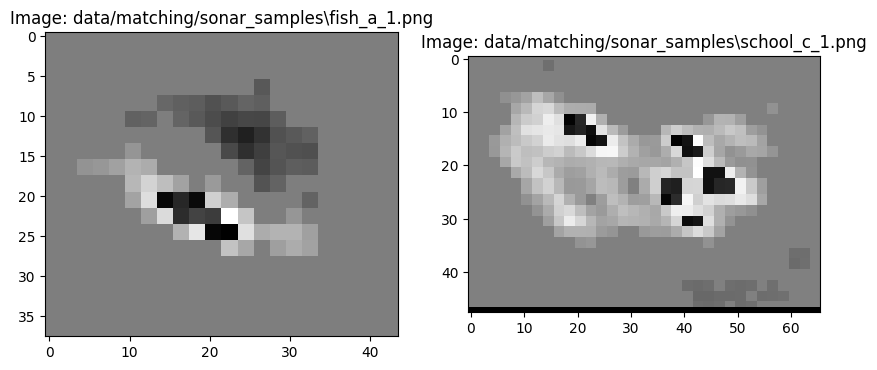

Matching score between data/matching/sonar_samples\fish_b_1.png and data/matching/sonar_samples\fish_b_2.png: 126.0423843825034


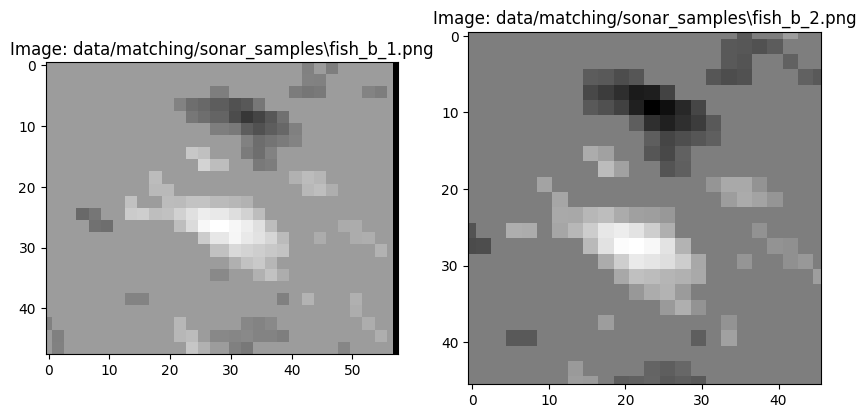

Matching score between data/matching/sonar_samples\fish_b_1.png and data/matching/sonar_samples\fish_a_1.png: 121.14152591729761


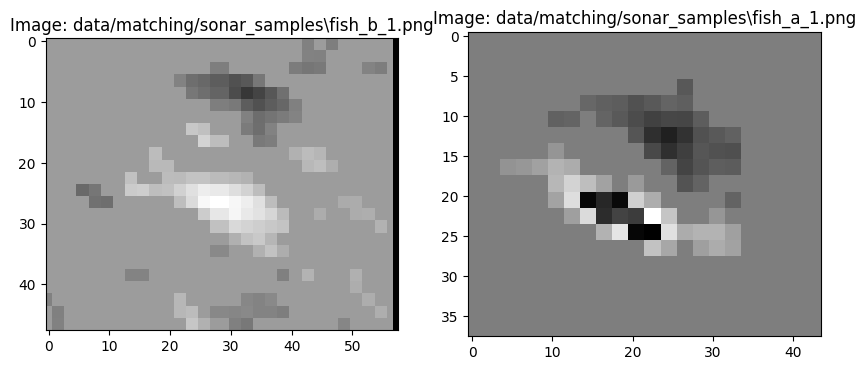

Matching score between data/matching/sonar_samples\fish_b_1.png and data/matching/sonar_samples\noise_a_1.png: 125.75827826526559


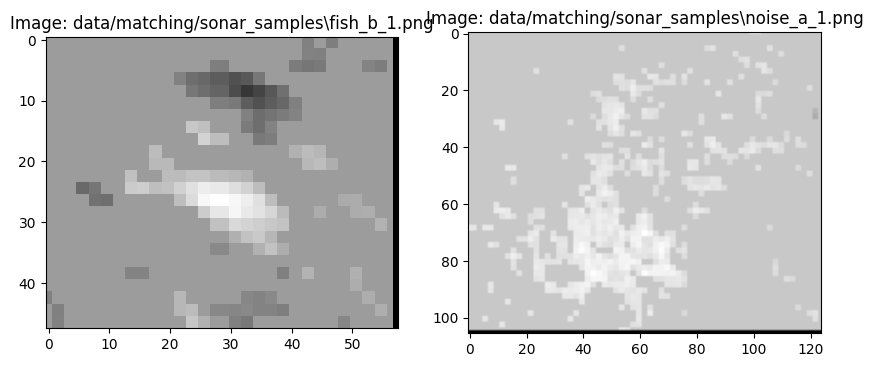

Matching score between data/matching/sonar_samples\fish_b_1.png and data/matching/sonar_samples\school_a_1.png: 121.67199783139063


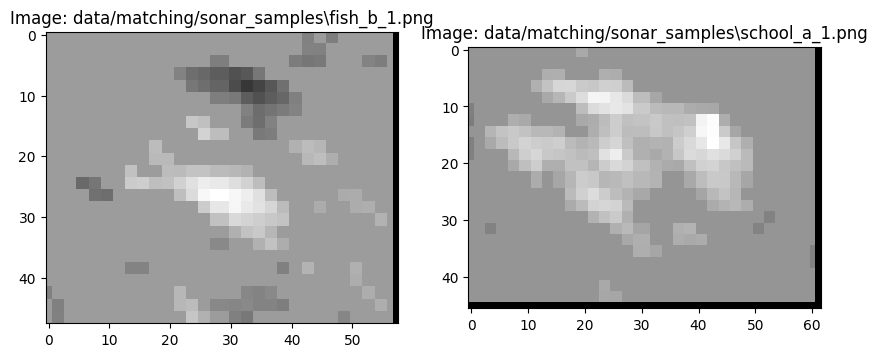

Matching score between data/matching/sonar_samples\fish_b_1.png and data/matching/sonar_samples\school_b_1.png: 121.78108505667561


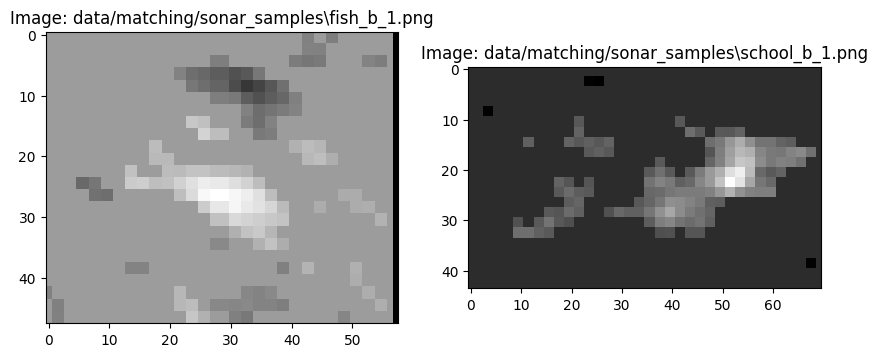

Matching score between data/matching/sonar_samples\fish_b_1.png and data/matching/sonar_samples\school_c_1.png: 122.62284980744545


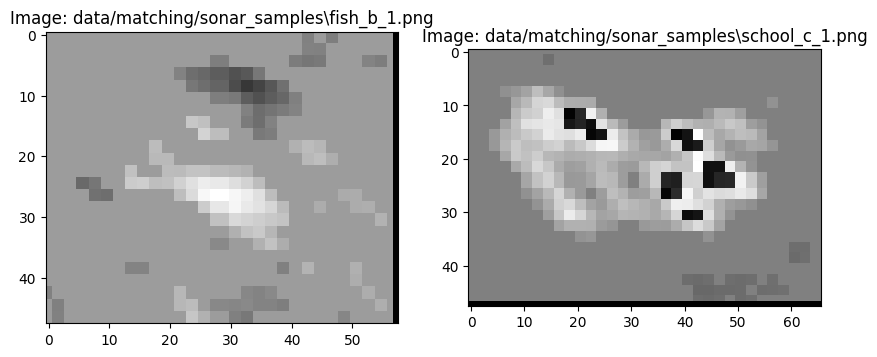

Matching score between data/matching/sonar_samples\noise_a_1.png and data/matching/sonar_samples\noise_a_2.png: 125.0714621975332


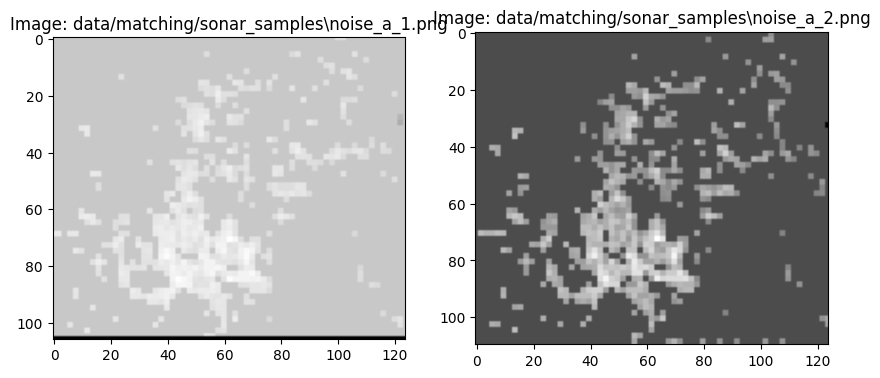

Matching score between data/matching/sonar_samples\noise_a_1.png and data/matching/sonar_samples\fish_a_1.png: 123.49231606716637


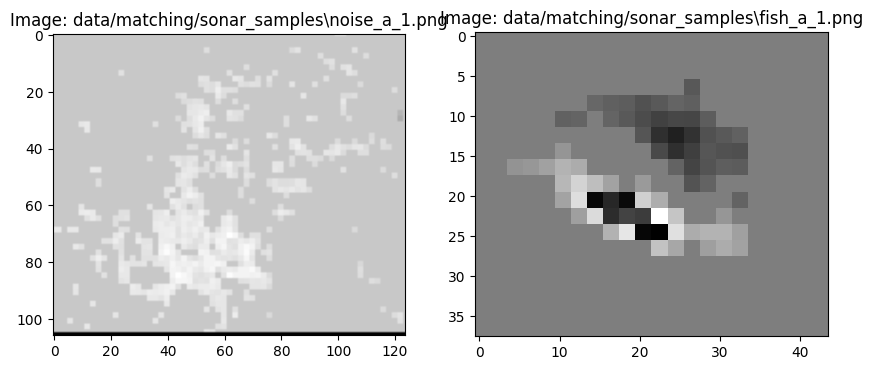

Matching score between data/matching/sonar_samples\noise_a_1.png and data/matching/sonar_samples\fish_b_1.png: 125.75827826526559


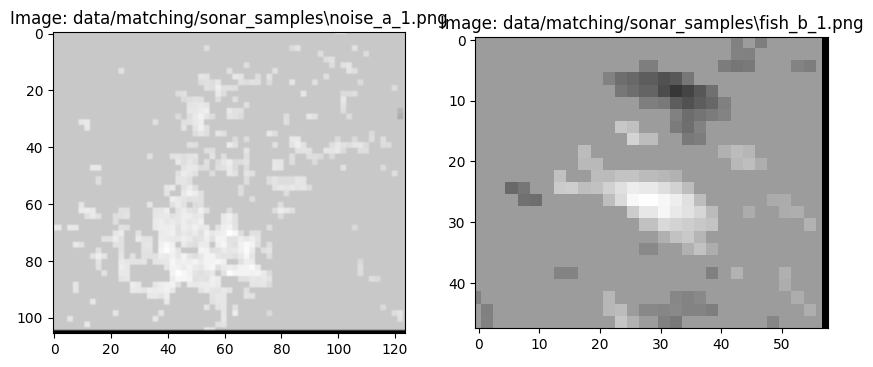

Matching score between data/matching/sonar_samples\noise_a_1.png and data/matching/sonar_samples\school_a_1.png: 123.32629318059782


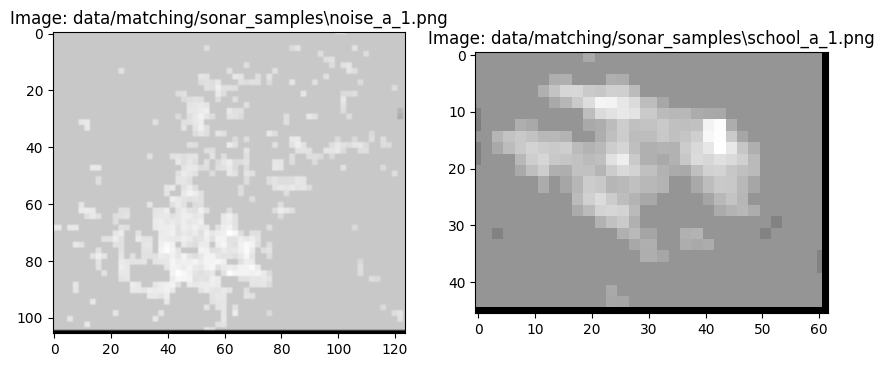

Matching score between data/matching/sonar_samples\noise_a_1.png and data/matching/sonar_samples\school_b_1.png: 123.41092603540008


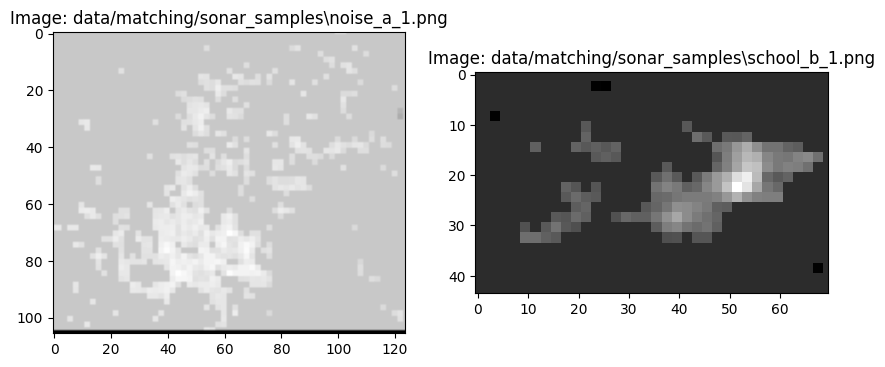

Matching score between data/matching/sonar_samples\noise_a_1.png and data/matching/sonar_samples\school_c_1.png: 122.8741570702355


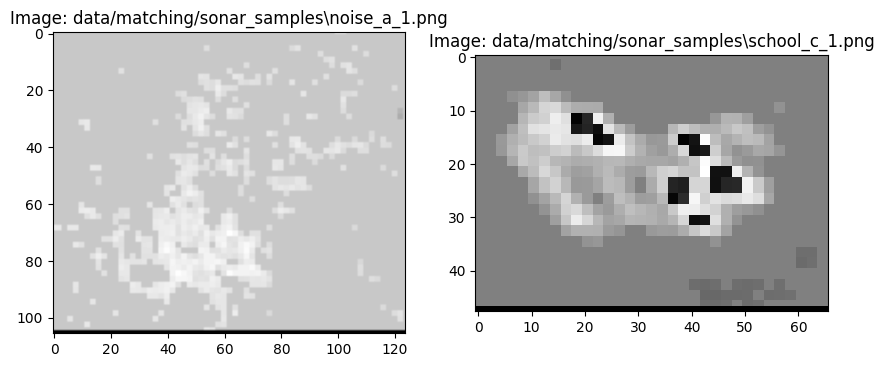

Matching score between data/matching/sonar_samples\school_a_1.png and data/matching/sonar_samples\school_a_2.png: 117.36472116243202


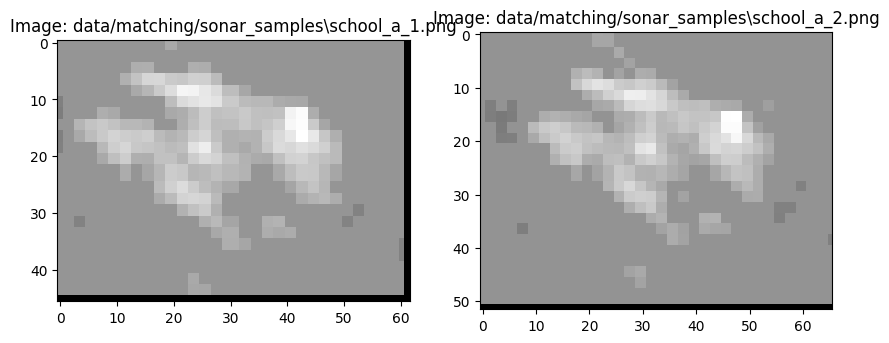

Matching score between data/matching/sonar_samples\school_a_1.png and data/matching/sonar_samples\fish_a_1.png: 118.74331612162938


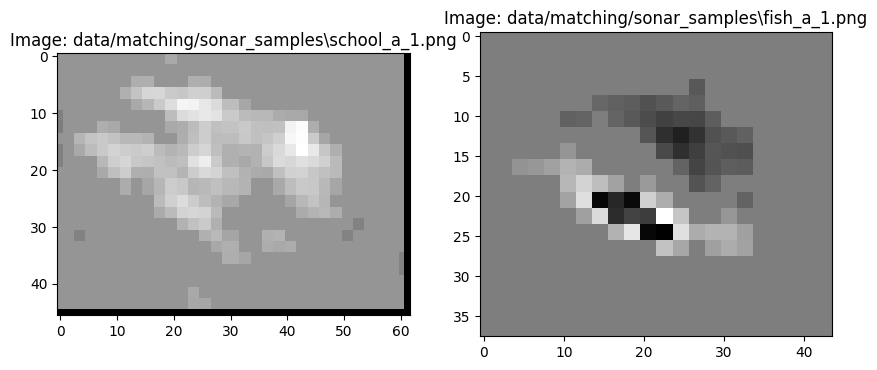

Matching score between data/matching/sonar_samples\school_a_1.png and data/matching/sonar_samples\fish_b_1.png: 121.67199783139063


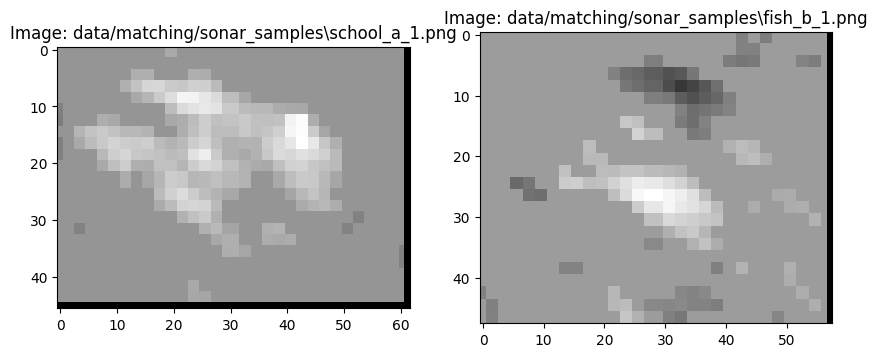

Matching score between data/matching/sonar_samples\school_a_1.png and data/matching/sonar_samples\noise_a_1.png: 123.32629318059782


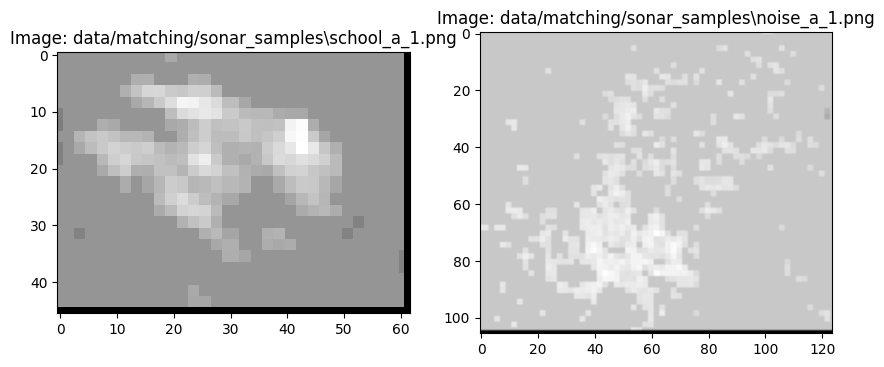

Matching score between data/matching/sonar_samples\school_a_1.png and data/matching/sonar_samples\school_b_1.png: 118.42250621837208


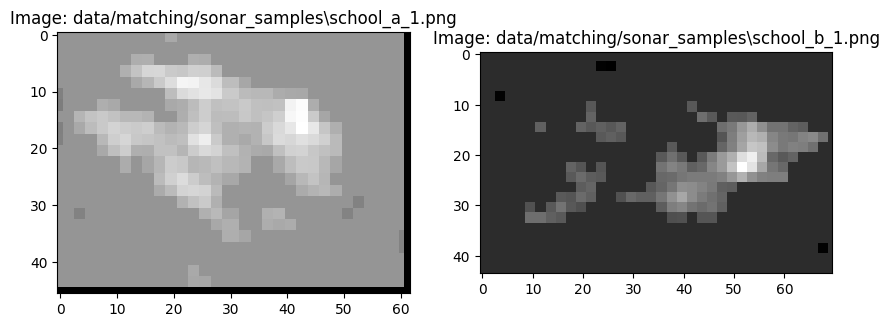

Matching score between data/matching/sonar_samples\school_a_1.png and data/matching/sonar_samples\school_c_1.png: 119.55736178139023


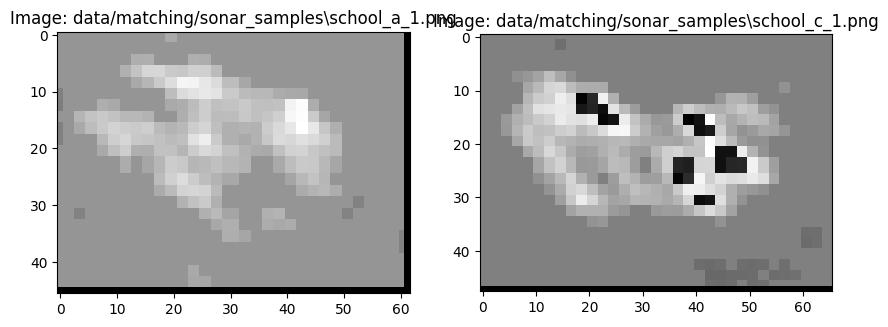

Matching score between data/matching/sonar_samples\school_b_1.png and data/matching/sonar_samples\school_b_2.png: 121.93444972958885


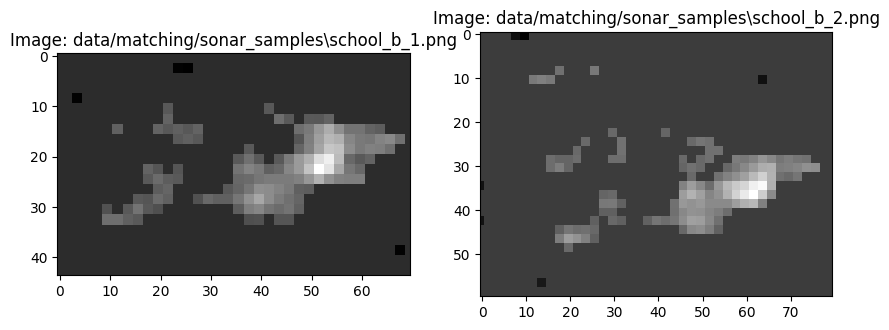

Matching score between data/matching/sonar_samples\school_b_1.png and data/matching/sonar_samples\fish_a_1.png: 119.10586692887578


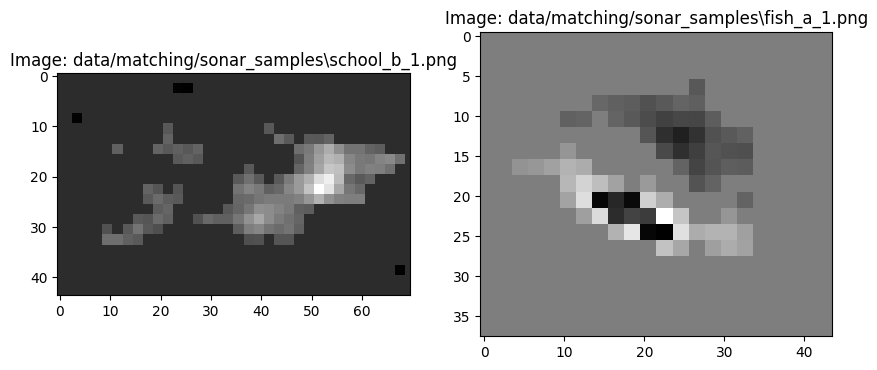

Matching score between data/matching/sonar_samples\school_b_1.png and data/matching/sonar_samples\fish_b_1.png: 121.78108505667561


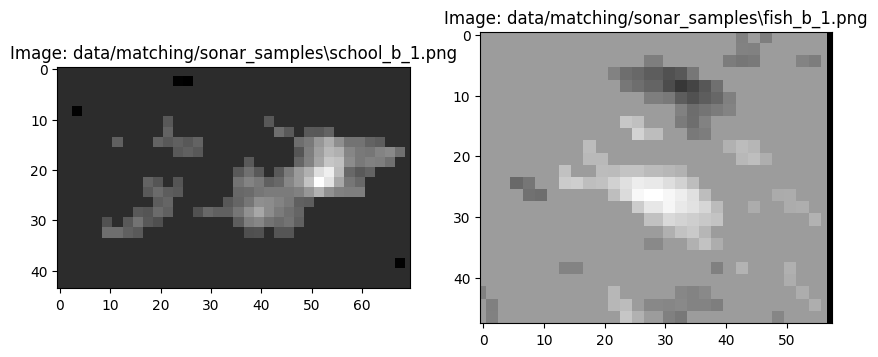

Matching score between data/matching/sonar_samples\school_b_1.png and data/matching/sonar_samples\noise_a_1.png: 123.41092603540008


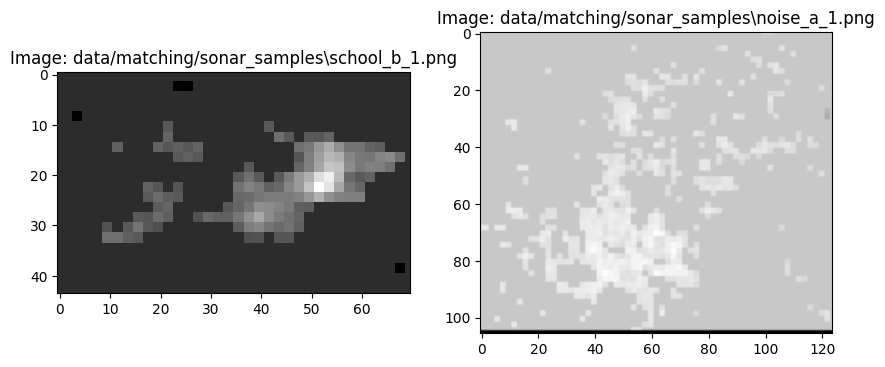

Matching score between data/matching/sonar_samples\school_b_1.png and data/matching/sonar_samples\school_a_1.png: 118.42250621837208


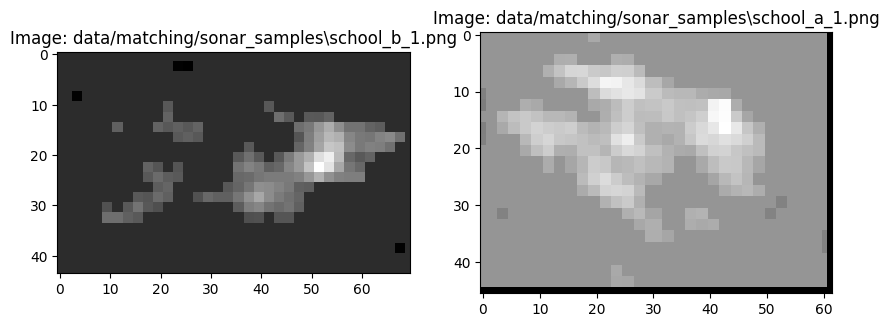

Matching score between data/matching/sonar_samples\school_b_1.png and data/matching/sonar_samples\school_c_1.png: 120.5020757020757


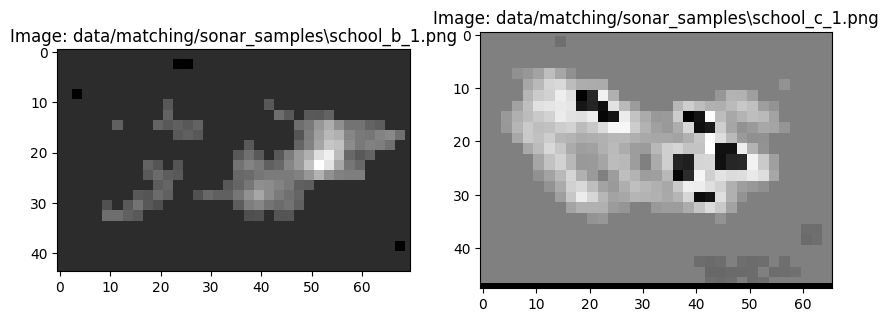

Matching score between data/matching/sonar_samples\school_c_1.png and data/matching/sonar_samples\school_c_2.png: 119.68622470578275


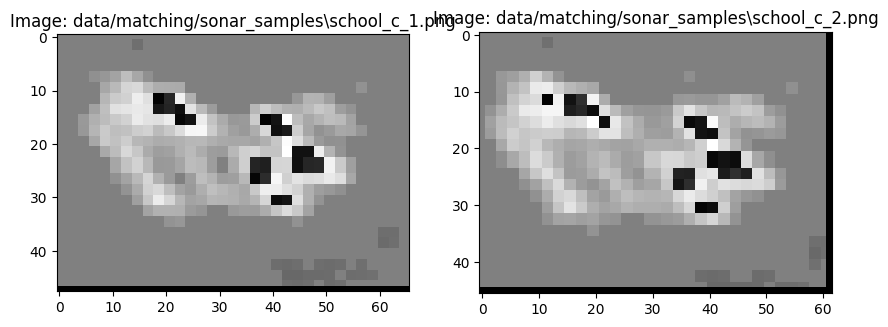

Matching score between data/matching/sonar_samples\school_c_1.png and data/matching/sonar_samples\fish_a_1.png: 116.53664328116568


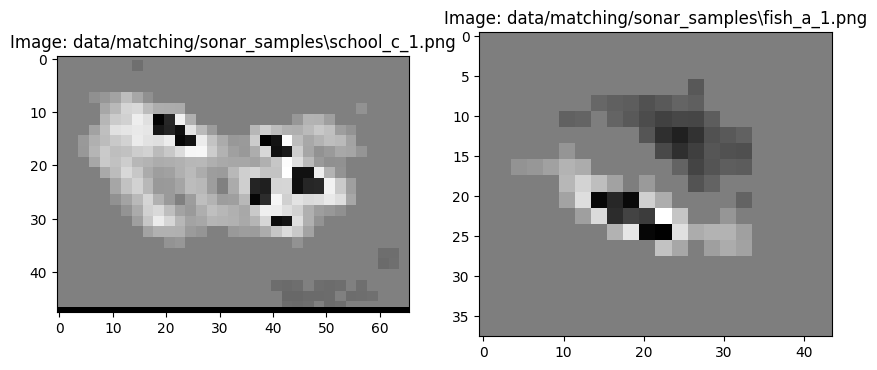

Matching score between data/matching/sonar_samples\school_c_1.png and data/matching/sonar_samples\fish_b_1.png: 122.62284980744545


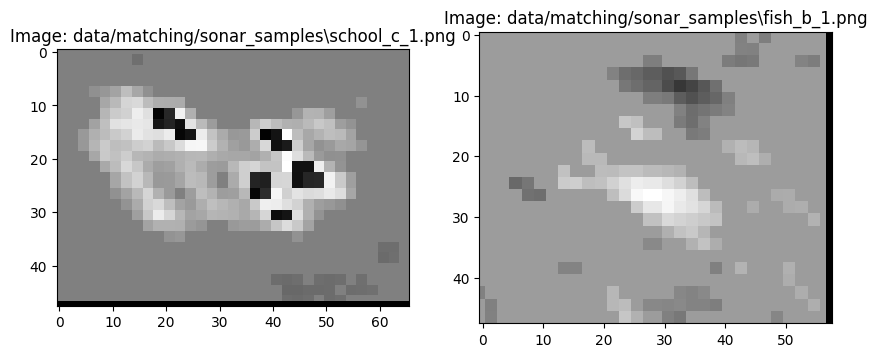

Matching score between data/matching/sonar_samples\school_c_1.png and data/matching/sonar_samples\noise_a_1.png: 122.8741570702355


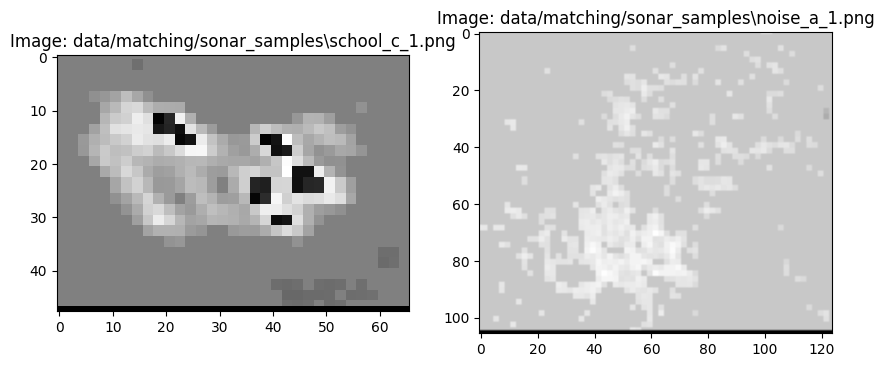

Matching score between data/matching/sonar_samples\school_c_1.png and data/matching/sonar_samples\school_a_1.png: 119.55736178139023


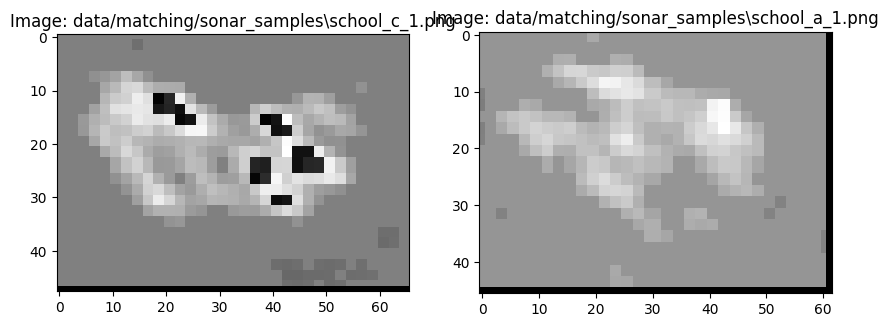

Matching score between data/matching/sonar_samples\school_c_1.png and data/matching/sonar_samples\school_b_1.png: 120.5020757020757


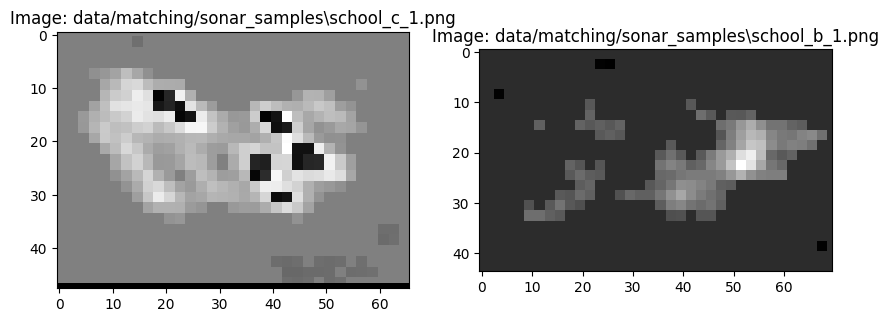

In [65]:
match_1_2_images(image_list)

In [66]:
import cv2

def match_1_2_images_with_orb(image_list):
    # Initialize the ORB detector
    orb = cv2.ORB_create()

    # Separate the list into _1 and _2 images
    one_images = [img for img in image_list if '_1.' in img]
    two_images = [img for img in image_list if '_2.' in img]

    # Create a dictionary to map each _1 image to its corresponding _2 image
    one_two_map = {one_img: two_img for one_img, two_img in zip(one_images, two_images)}

    # Initialize the BFMatcher with default params
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Iterate over every _1 image
    for one_img in one_images:
        # Load the _1 image
        img1 = cv2.imread(one_img, cv2.IMREAD_GRAYSCALE)
        kp1, des1 = orb.detectAndCompute(img1, None)

        # Match with the corresponding _2 image
        two_img = one_two_map[one_img]
        img2 = cv2.imread(two_img, cv2.IMREAD_GRAYSCALE)
        kp2, des2 = orb.detectAndCompute(img2, None)

        # Match descriptors
        matches = bf.match(des1, des2)

        # Sort them in the order of their distance
        matches = sorted(matches, key = lambda x:x.distance)

        print(f"Matching score between {one_img} and {two_img}: {len(matches)}")
        display_images(one_img, img1, two_img, img2)

        # Match with all the other _1 images
        for other_one_img in one_images:
            if other_one_img != one_img:
                img2 = cv2.imread(other_one_img, cv2.IMREAD_GRAYSCALE)
                kp2, des2 = orb.detectAndCompute(img2, None)

                # Match descriptors
                matches = bf.match(des1, des2)

                # Sort them in the order of their distance
                matches = sorted(matches, key = lambda x:x.distance)

                print(f"Matching score between {one_img} and {other_one_img}: {len(matches)}")
                display_images(one_img, img1, other_one_img, img2)

Matching score between data/matching/sonar_samples\fish_a_1.png and data/matching/sonar_samples\fish_a_2.png: 0


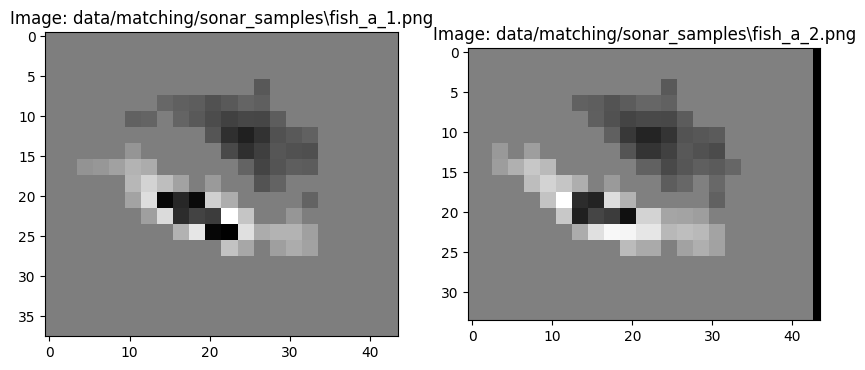

Matching score between data/matching/sonar_samples\fish_a_1.png and data/matching/sonar_samples\fish_b_1.png: 0


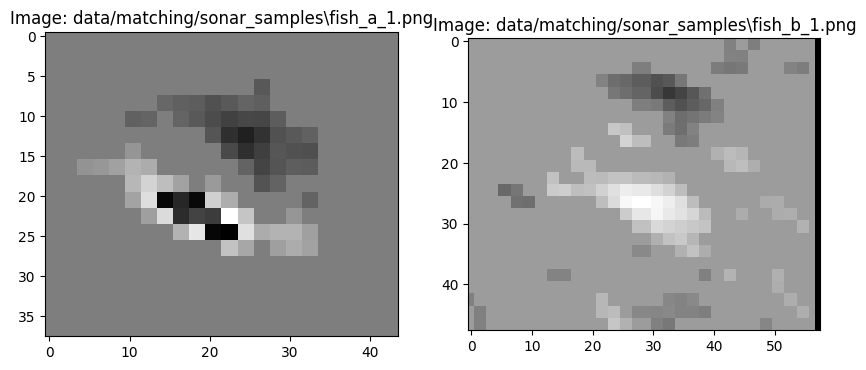

Matching score between data/matching/sonar_samples\fish_a_1.png and data/matching/sonar_samples\noise_a_1.png: 0


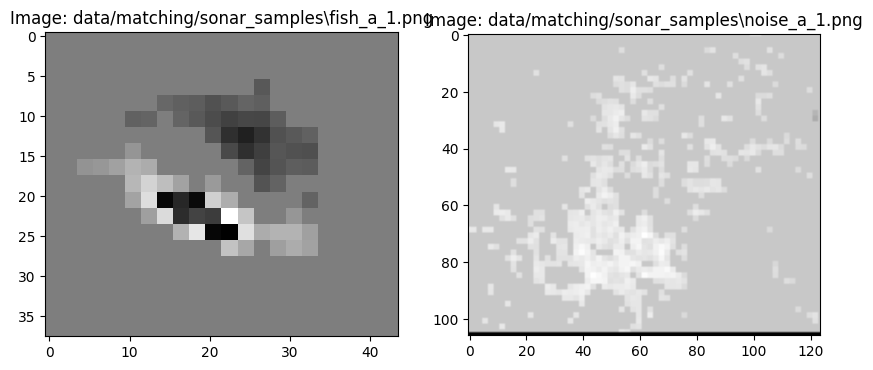

Matching score between data/matching/sonar_samples\fish_a_1.png and data/matching/sonar_samples\school_a_1.png: 0


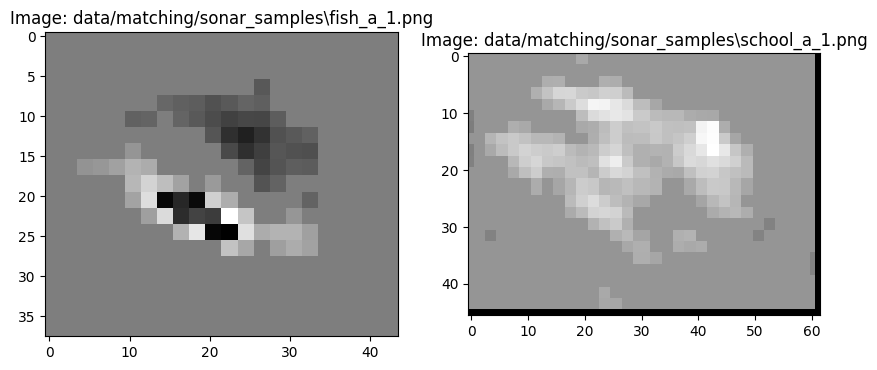

Matching score between data/matching/sonar_samples\fish_a_1.png and data/matching/sonar_samples\school_b_1.png: 0


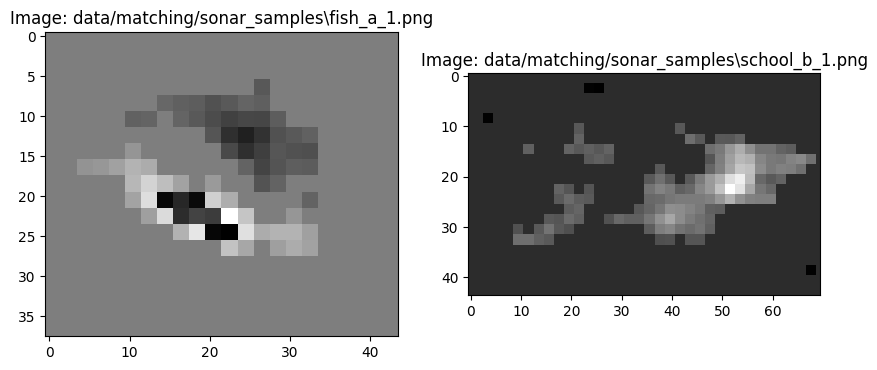

Matching score between data/matching/sonar_samples\fish_a_1.png and data/matching/sonar_samples\school_c_1.png: 0


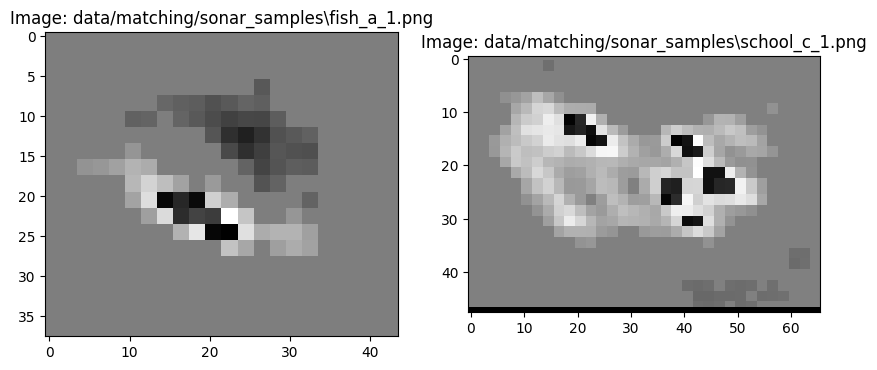

Matching score between data/matching/sonar_samples\fish_b_1.png and data/matching/sonar_samples\fish_b_2.png: 0


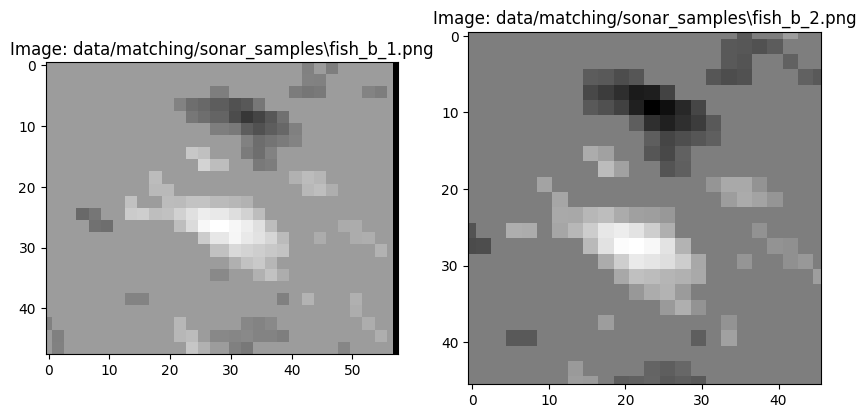

Matching score between data/matching/sonar_samples\fish_b_1.png and data/matching/sonar_samples\fish_a_1.png: 0


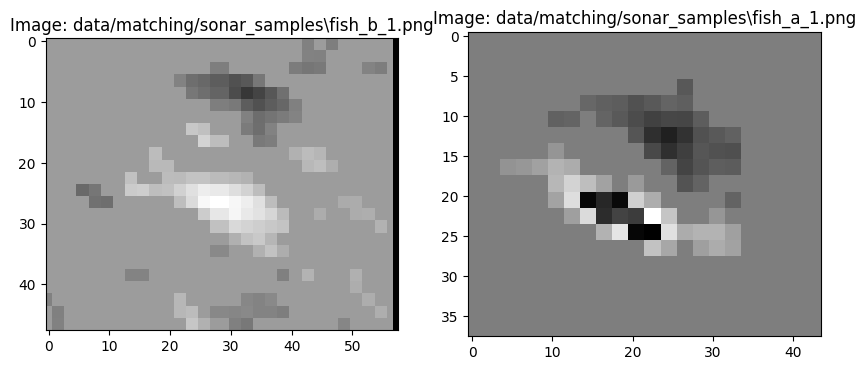

Matching score between data/matching/sonar_samples\fish_b_1.png and data/matching/sonar_samples\noise_a_1.png: 0


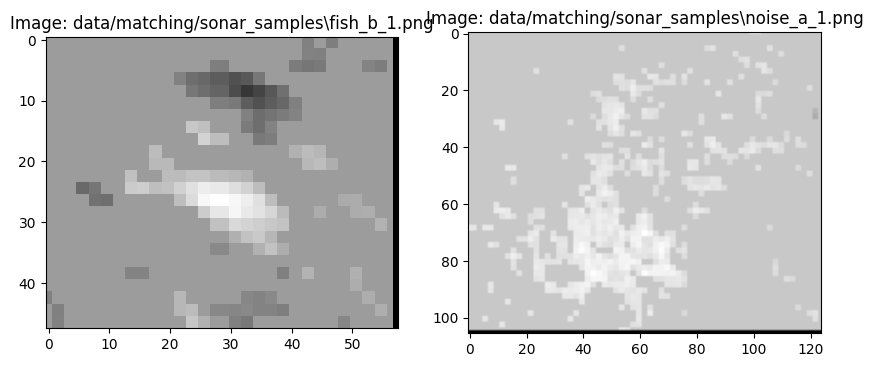

Matching score between data/matching/sonar_samples\fish_b_1.png and data/matching/sonar_samples\school_a_1.png: 0


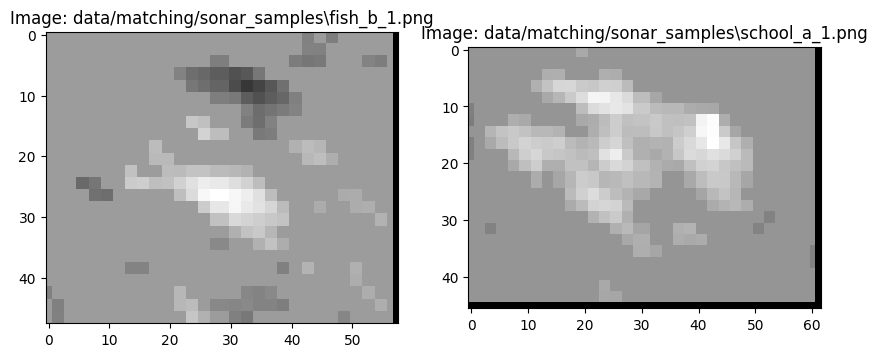

Matching score between data/matching/sonar_samples\fish_b_1.png and data/matching/sonar_samples\school_b_1.png: 0


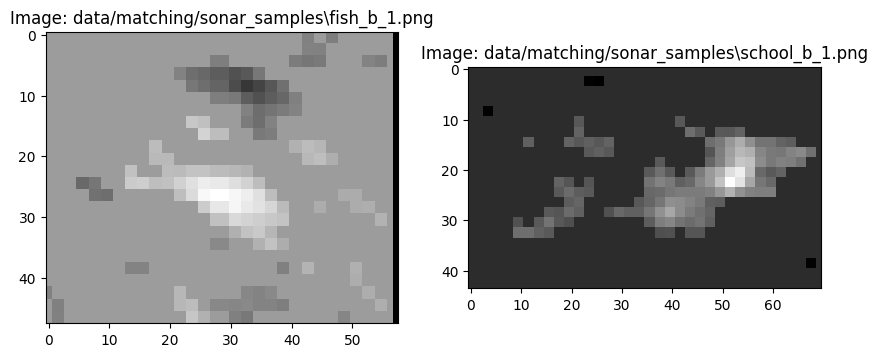

Matching score between data/matching/sonar_samples\fish_b_1.png and data/matching/sonar_samples\school_c_1.png: 0


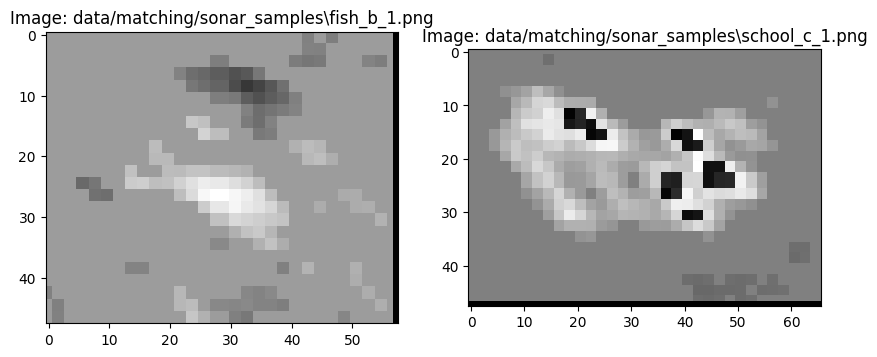

Matching score between data/matching/sonar_samples\noise_a_1.png and data/matching/sonar_samples\noise_a_2.png: 3


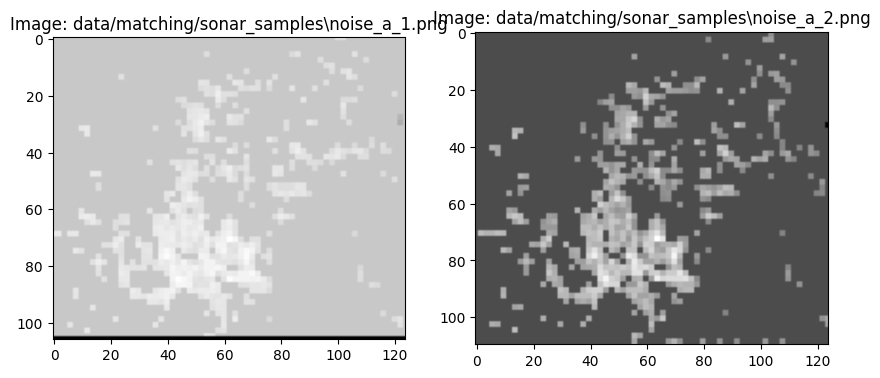

error: OpenCV(5.0.0-pre) D:\a\opencv-python\opencv-python\opencv\modules\core\src\batch_distance.cpp:275: error: (-215:Assertion failed) type == src2.type() && src1.cols == src2.cols && (type == CV_32F || type == CV_8U) in function 'cv::batchDistance'


In [67]:
match_1_2_images_with_orb(image_list)

# Histogram Similarity

In [21]:
import cv2

# Helper function to calculate the similarity score between two images
def calculate_hist_similarity(img1_path, img2_path):
    # Load the images in grayscale
    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    # Calculate the histograms
    hist_img1 = cv2.calcHist([img1], [0], None, [256], [0, 256])
    hist_img2 = cv2.calcHist([img2], [0], None, [256], [0, 256])

    # Normalize the histograms
    cv2.normalize(hist_img1, hist_img1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    cv2.normalize(hist_img2, hist_img2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

    # Calculate the similarity score
    metric_val = cv2.compareHist(hist_img1, hist_img2, cv2.HISTCMP_BHATTACHARYYA)
    return round(metric_val, 2)


def match_1_2_images(image_list, similarity_fn, display_images=False):
    # Separate the list into _1 and _2 images
    one_images = [img for img in image_list if '_1.' in img]
    two_images = [img for img in image_list if '_2.' in img]

    # Create a dictionary to map each _1 image to its corresponding _2 image
    one_two_map = {one_img: two_img for one_img, two_img in zip(one_images, two_images)}

    # Iterate over every _1 image
    for one_img in one_images:
        # Match with the corresponding _2 image
        two_img = one_two_map[one_img]
        print(f"Similarity Score between {one_img} and {two_img}: ", similarity_fn(one_img, two_img))

        # Match with all the other _1 images
        for other_one_img in one_images:
            if other_one_img != one_img:
                print(f"Similarity Score between {one_img} and {other_one_img}: ", similarity_fn(one_img, other_one_img))

In [22]:
match_1_2_images(image_list, calculate_hist_similarity)

Similarity Score between ../../../data/matching/sonar_samples\fish_a_1.png and ../../../data/matching/sonar_samples\fish_a_2.png:  0.33
Similarity Score between ../../../data/matching/sonar_samples\fish_a_1.png and ../../../data/matching/sonar_samples\fish_b_1.png:  0.34
Similarity Score between ../../../data/matching/sonar_samples\fish_a_1.png and ../../../data/matching/sonar_samples\noise_a_1.png:  0.41
Similarity Score between ../../../data/matching/sonar_samples\fish_a_1.png and ../../../data/matching/sonar_samples\school_a_1.png:  0.43
Similarity Score between ../../../data/matching/sonar_samples\fish_a_1.png and ../../../data/matching/sonar_samples\school_b_1.png:  0.37
Similarity Score between ../../../data/matching/sonar_samples\fish_a_1.png and ../../../data/matching/sonar_samples\school_c_1.png:  0.47
Similarity Score between ../../../data/matching/sonar_samples\fish_b_1.png and ../../../data/matching/sonar_samples\fish_b_2.png:  0.25
Similarity Score between ../../../data/ma

# FFT similarity

In [26]:
import numpy as np
import cv2

# Helper function to calculate the similarity score between two images
def calculate_fft_similarity(img1_path, img2_path):
    # Load the images in grayscale
    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    # Resize the images to the size of the smaller one
    img1 = cv2.resize(img1, (64, 64))
    img2 = cv2.resize(img2, (64, 64))

    # Calculate the FFT of the images
    fft_img1 = np.fft.fft2(img1)
    fft_img2 = np.fft.fft2(img2)

    # Shift the zero-frequency component to the center of the spectrum
    fft_shift_img1 = np.fft.fftshift(fft_img1)
    fft_shift_img2 = np.fft.fftshift(fft_img2)

    # Calculate the magnitude spectrum of the FFT
    magnitude_spectrum_img1 = np.abs(fft_shift_img1)
    magnitude_spectrum_img2 = np.abs(fft_shift_img2)

    # Normalize the magnitude spectrums
    magnitude_spectrum_img1 = (magnitude_spectrum_img1 - np.min(magnitude_spectrum_img1)) / (np.max(magnitude_spectrum_img1) - np.min(magnitude_spectrum_img1))
    magnitude_spectrum_img2 = (magnitude_spectrum_img2 - np.min(magnitude_spectrum_img2)) / (np.max(magnitude_spectrum_img2) - np.min(magnitude_spectrum_img2))

    # Calculate the similarity score
    metric_val = cv2.compareHist(np.float32(magnitude_spectrum_img1.flatten()), np.float32(magnitude_spectrum_img2.flatten()), cv2.HISTCMP_BHATTACHARYYA)
    return round(metric_val, 2)

match_1_2_images(image_list, calculate_fft_similarity)

Similarity Score between ../../../data/matching/sonar_samples\fish_a_1.png and ../../../data/matching/sonar_samples\fish_a_2.png:  0.28
Similarity Score between ../../../data/matching/sonar_samples\fish_a_1.png and ../../../data/matching/sonar_samples\fish_b_1.png:  0.36
Similarity Score between ../../../data/matching/sonar_samples\fish_a_1.png and ../../../data/matching/sonar_samples\noise_a_1.png:  0.39
Similarity Score between ../../../data/matching/sonar_samples\fish_a_1.png and ../../../data/matching/sonar_samples\school_a_1.png:  0.41
Similarity Score between ../../../data/matching/sonar_samples\fish_a_1.png and ../../../data/matching/sonar_samples\school_b_1.png:  0.32
Similarity Score between ../../../data/matching/sonar_samples\fish_a_1.png and ../../../data/matching/sonar_samples\school_c_1.png:  0.29
Similarity Score between ../../../data/matching/sonar_samples\fish_b_1.png and ../../../data/matching/sonar_samples\fish_b_2.png:  0.32
Similarity Score between ../../../data/ma